#Import Necessary Libraries

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Bidirectional, Conv1D, BatchNormalization

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Read Dataset

In [46]:
df = pd.read_csv("Honda_stock.csv")
df.head()

,date,open,high,low,close,volume
0,1980-03-17,2.5868,2.6317,2.5868,2.5868,26000
1,1980-03-18,2.6317,2.6317,2.6317,2.6317,2000
2,1980-03-19,2.5998,2.5998,2.5998,2.5998,2000
3,1980-03-21,2.5998,2.5998,2.5998,2.5998,2000
4,1980-03-24,2.6157,2.6157,2.6157,2.6157,24000


In [47]:
df = df[['date', 'close']]

df

,date,close
0,1980-03-17,2.5868
1,1980-03-18,2.6317
2,1980-03-19,2.5998
3,1980-03-21,2.5998
4,1980-03-24,2.6157
...,...,...
11077,2024-03-18,36.4300
11078,2024-03-19,36.8500
11079,2024-03-20,37.0800
11080,2024-03-21,37.4400


In [48]:
df['date']

0        1980-03-17
1        1980-03-18
2        1980-03-19
3        1980-03-21
4        1980-03-24
            ...    
11077    2024-03-18
11078    2024-03-19
11079    2024-03-20
11080    2024-03-21
11081    2024-03-22
Name: date, Length: 11082, dtype: object

In [49]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [50]:
df['date'] = df['date'].apply(str_to_datetime)
df['date']

0       1980-03-17
1       1980-03-18
2       1980-03-19
3       1980-03-21
4       1980-03-24
           ...    
11077   2024-03-18
11078   2024-03-19
11079   2024-03-20
11080   2024-03-21
11081   2024-03-22
Name: date, Length: 11082, dtype: datetime64[ns]

In [51]:
df.index = df.pop('date')
df

,close
date,
1980-03-17,2.5868
1980-03-18,2.6317
1980-03-19,2.5998
1980-03-21,2.5998
1980-03-24,2.6157
...,...
2024-03-18,36.4300
2024-03-19,36.8500
2024-03-20,37.0800


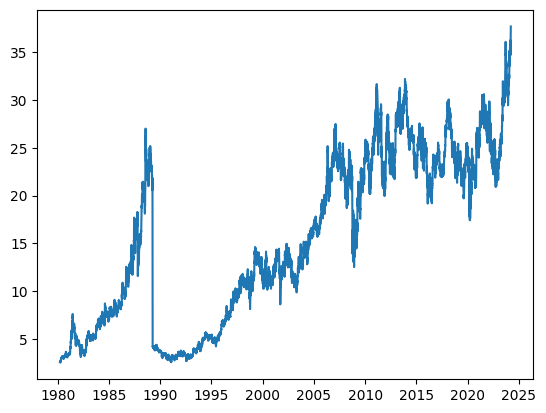

In [52]:
plt.plot(df.index, df['close'])

In [53]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2014-03-01',
                                '2024-03-22',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2014-03-01,27.4543,27.3179,27.5982,27.3103
1,2014-03-04,27.5982,27.3103,27.5755,27.9770
2,2014-03-05,27.3103,27.5755,27.9770,27.9694
3,2014-03-06,27.5755,27.9770,27.9694,28.2573
4,2014-03-07,27.9770,27.9694,28.2573,28.1209
...,...,...,...,...,...
2528,2024-03-18,35.1600,35.2400,36.0600,36.4300
2529,2024-03-19,35.2400,36.0600,36.4300,36.8500
2530,2024-03-20,36.0600,36.4300,36.8500,37.0800
2531,2024-03-21,36.4300,36.8500,37.0800,37.4400


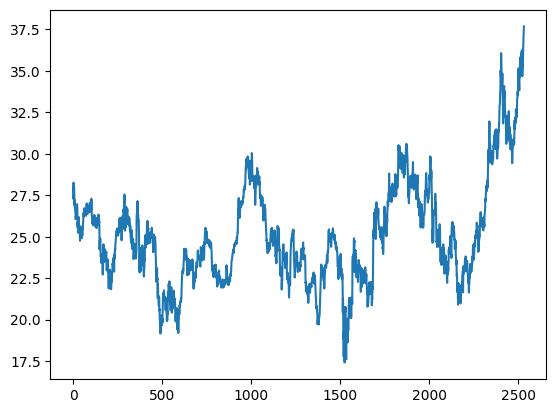

In [54]:
plt.plot(windowed_df.index, windowed_df['Target'])

In [55]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2533,), (2533, 3, 1), (2533,))

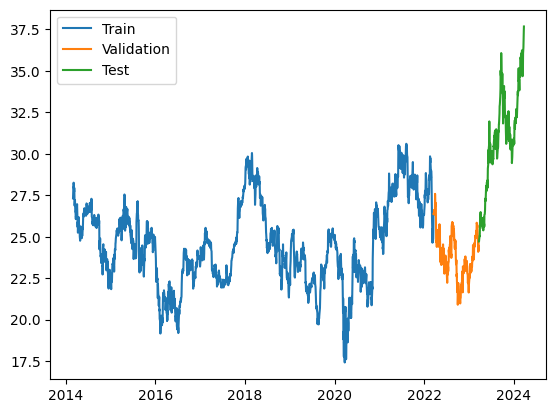

In [56]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
windowed_df.to_csv("train_data.csv", index=False)

#**Bi-LSTM Model**

In [74]:
model = Sequential([layers.Input((3, 1)),
                    layers.Bidirectional(layers.LSTM(16, activation='relu')),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_hisory = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150)

Epoch 1/150
64/64 [==============================] - 4s 24ms/step - loss: 725.0132 - mean_absolute_error: 26.7384 - val_loss: 544.9219 - val_mean_absolute_error: 23.3055
Epoch 2/150
64/64 [==============================] - 0s 5ms/step - loss: 280.4172 - mean_absolute_error: 14.7133 - val_loss: 11.5920 - val_mean_absolute_error: 3.2061
Epoch 3/150
64/64 [==============================] - 0s 7ms/step - loss: 3.1546 - mean_absolute_error: 1.4191 - val_loss: 0.7331 - val_mean_absolute_error: 0.6989
Epoch 4/150
64/64 [==============================] - 0s 6ms/step - loss: 1.5302 - mean_absolute_error: 1.0007 - val_loss: 0.6891 - val_mean_absolute_error: 0.6885
Epoch 5/150
64/64 [==============================] - 0s 6ms/step - loss: 0.8662 - mean_absolute_error: 0.7476 - val_loss: 0.2686 - val_mean_absolute_error: 0.4095
Epoch 6/150
64/64 [==============================] - 0s 7ms/step - loss: 0.4032 - mean_absolute_error: 0.4911 - val_loss: 0.2074 - val_mean_absolute_error: 0.3545
Epoch 7/150

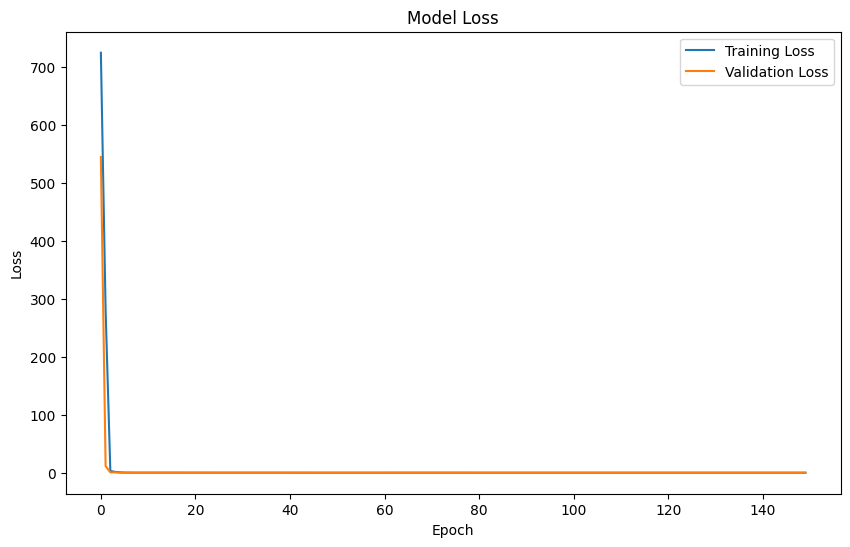

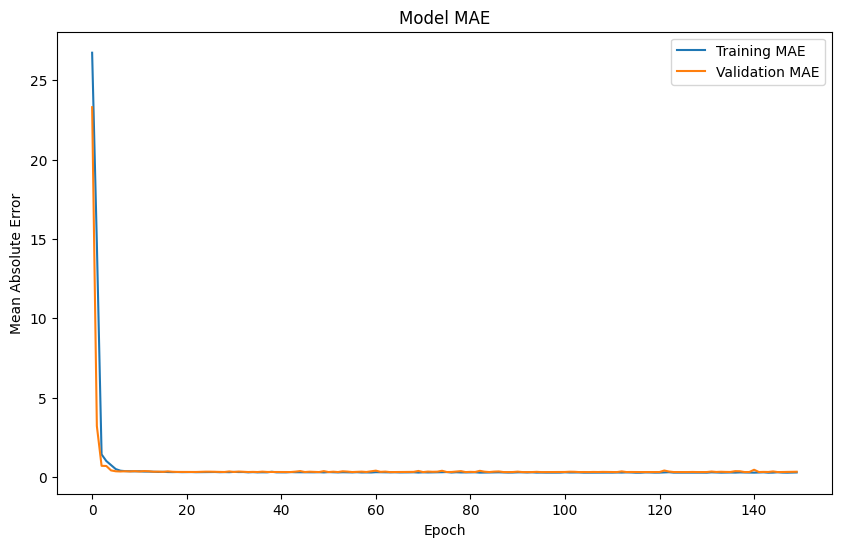

In [75]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(model_hisory.history['loss'], label='Training Loss')
plt.plot(model_hisory.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# If you have other metrics (like 'mae' in your case), you can plot them similarly
plt.figure(figsize=(10, 6))
plt.plot(model_hisory.history['mean_absolute_error'], label='Training MAE')
plt.plot(model_hisory.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()


8/8 [==============================] - 0s 3ms/step


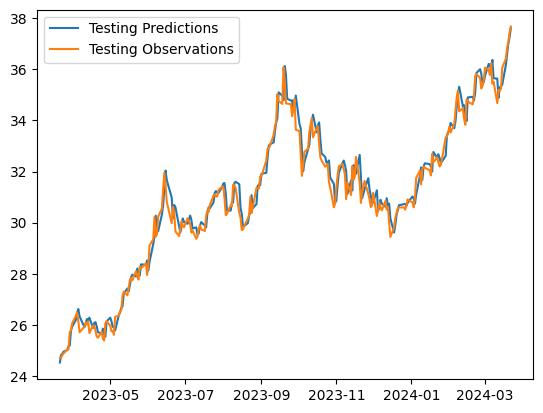

In [76]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

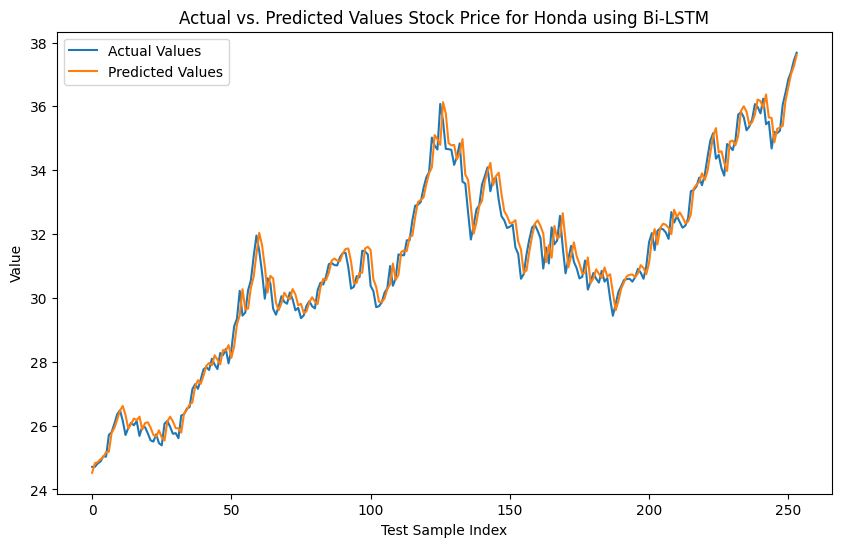

In [77]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Actual vs. Predicted Values Stock Price for Honda using Bi-LSTM')
plt.xlabel('Test Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [78]:
# Assuming y_test are your true values and test_predictions are the predictions from your model
mape = (mean_absolute_percentage_error(y_test, test_predictions) * 100)
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mse)  # Calculating RMSE
r2 = r2_score(y_test, test_predictions)  # Calculating R-squared score

print("Metrics used to evaluate Bi-LSTM model")

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R² score: {r2:.4f}")

Metrics used to evaluate Bi-LSTM model
MAE: 0.3389
MSE: 0.1974
RMSE: 0.4443
MAPE: 1.0867
R² score: 0.9778


#**1-D CNN-Bi-LSTM**

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             256       
                                                                 
 bidirectional_16 (Bidirect  (None, 64)                24832     
 ional)                                                          
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 25153 (98.25 KB)
Trainable params: 25153 (98.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
64/64 [==============================] - 4s 11ms/step - loss: 195.6820 - mean_absolute_error: 10.8574 - val_loss: 1.2266 - val_mean_absolute_error: 1.0181
Epoch 2/200
64/64 [=============================

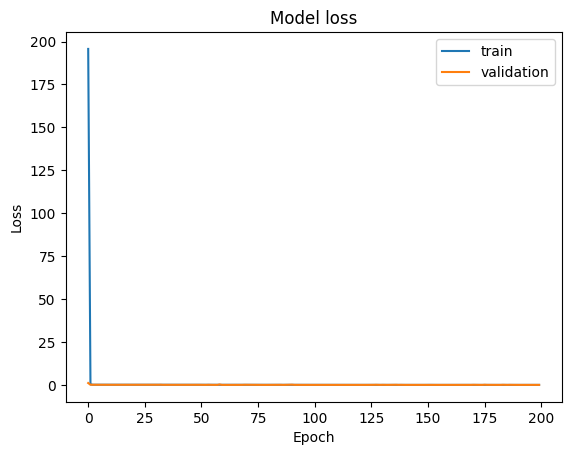

In [79]:
# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(3, 1)),
    Bidirectional(LSTM(32, activation='relu')),
    Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
# Summary of the model to understand its structure
model.summary()

# Fit the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val))

# After training, you might want to plot the training and validation loss
# to see how your model has improved over time and to check for overfitting.

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

8/8 [==============================] - 0s 2ms/step


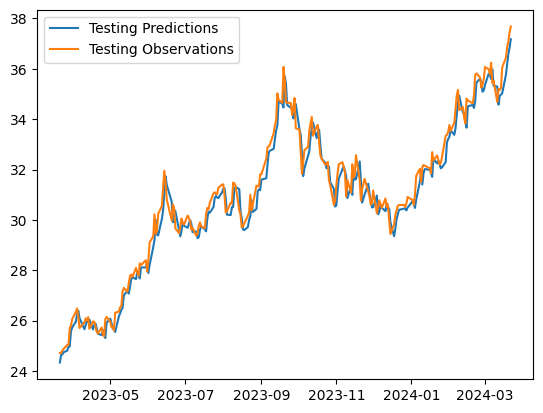

In [80]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

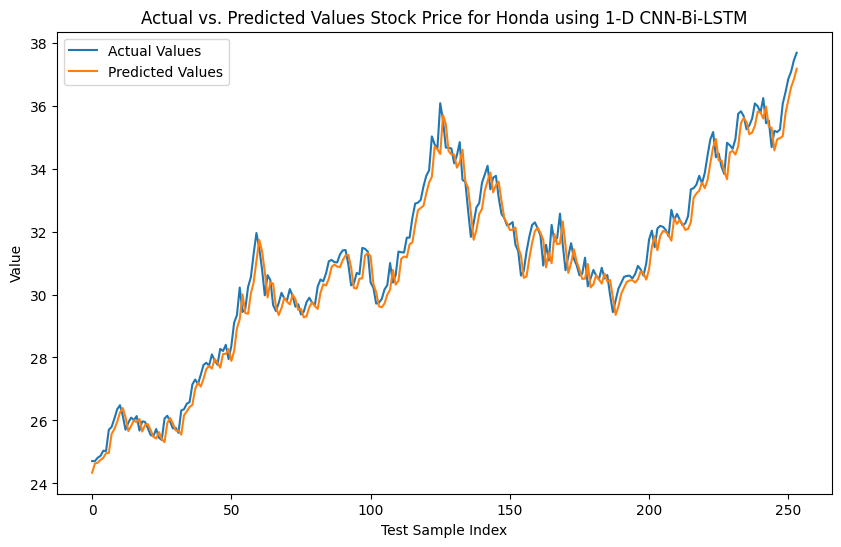

In [81]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Actual vs. Predicted Values Stock Price for Honda using 1-D CNN-Bi-LSTM')
plt.xlabel('Test Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [82]:
# Assuming y_test are your true values and test_predictions are the predictions from your model
mape = (mean_absolute_percentage_error(y_test, test_predictions) * 100)
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mse)  # Calculating RMSE
r2 = r2_score(y_test, test_predictions)  # Calculating R-squared score

print("Metrics used to evaluate 1-D CNN-Bi-LSTM")

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R² score: {r2:.4f}")

Metrics used to evaluate 1-D CNN-Bi-LSTM
MAE: 0.3852
MSE: 0.2322
RMSE: 0.4818
MAPE: 1.2269
R² score: 0.9739


#**LSTM-RNN**

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                16896     
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20065 (78.38 KB)
Trainable params: 20065 (78.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
64/64 [==============================] - 2s 8ms/step - loss: 183.0382 - mean_absolute_error: 10.1134 - val_loss: 2.3897 - val_mean_absolu

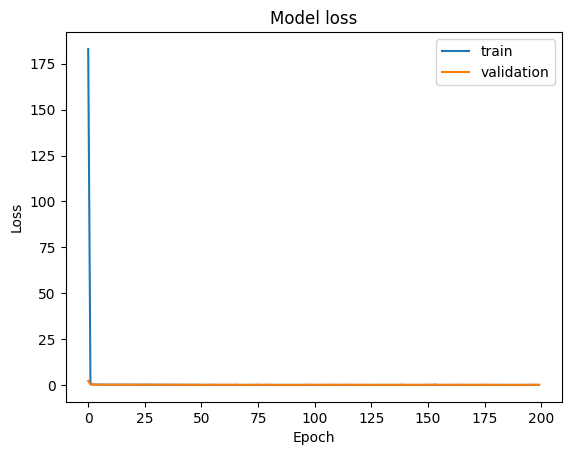

In [83]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
# Summary of the model to understand its structure
model.summary()

# Fit the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val))

# After training, you might want to plot the training and validation loss
# to see how your model has improved over time and to check for overfitting.

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

8/8 [==============================] - 0s 3ms/step


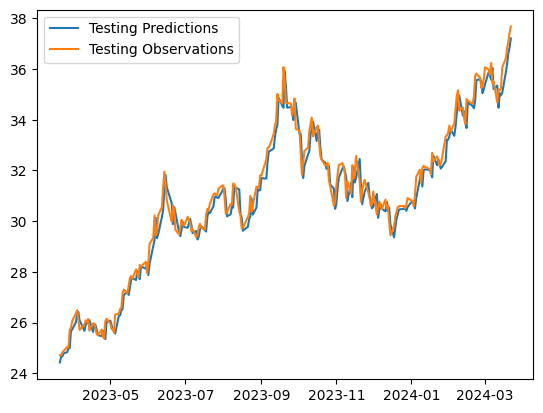

In [84]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

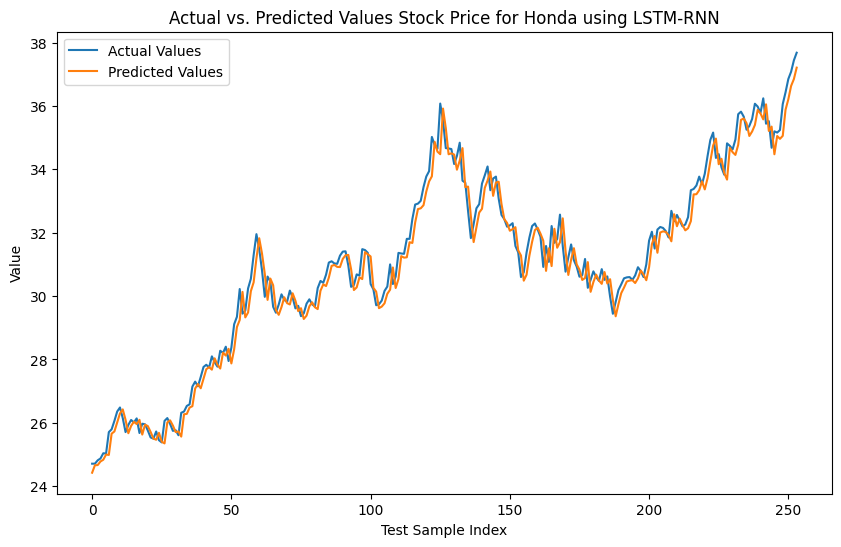

In [85]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Actual vs. Predicted Values Stock Price for Honda using LSTM-RNN')
plt.xlabel('Test Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [86]:
# Assuming y_test are your true values and test_predictions are the predictions from your model
mape = (mean_absolute_percentage_error(y_test, test_predictions) * 100)
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mse)  # Calculating RMSE
r2 = r2_score(y_test, test_predictions)  # Calculating R-squared score

print("Metrics used to evaluate LSTM-RNN")

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R² score: {r2:.4f}")

Metrics used to evaluate LSTM-RNN
MAE: 0.3683
MSE: 0.2155
RMSE: 0.4643
MAPE: 1.1718
R² score: 0.9758


#**RNN**

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 64)             4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7361 (28.75 KB)
Trainable params: 7361 (28.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
64/64 [==============================] - 3s 14ms/step - loss: 160.1577 - mean_absolute_error: 8.9616 - val_loss: 1.6000 - val_mean_absolute_error: 1.1698
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 0.4463 - mean_absolute_error: 0.5029 - val_l

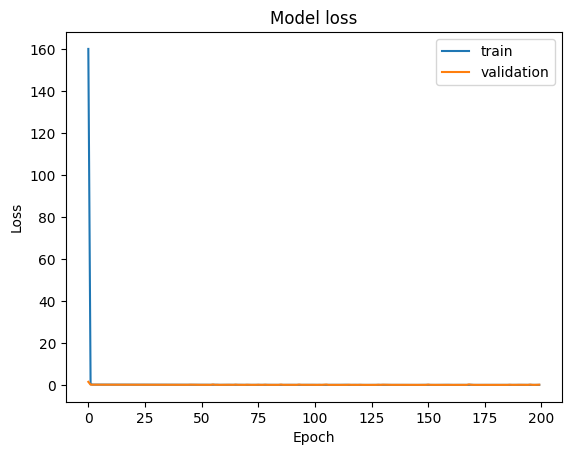

In [87]:
model = Sequential([
    SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    SimpleRNN(units=32, activation='relu'),
    Dense(units=1)
])


model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
# Summary of the model to understand its structure
model.summary()

# Fit the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val))

# After training, you might want to plot the training and validation loss
# to see how your model has improved over time and to check for overfitting.

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

8/8 [==============================] - 0s 2ms/step


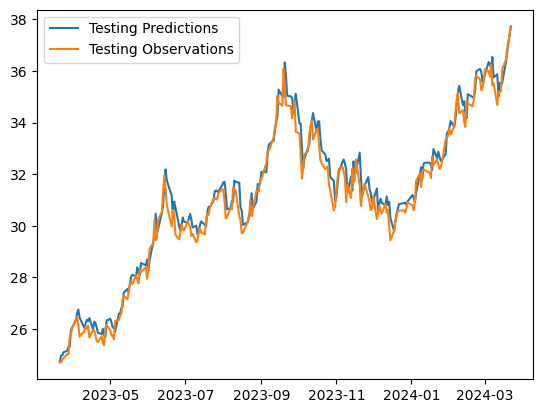

In [88]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

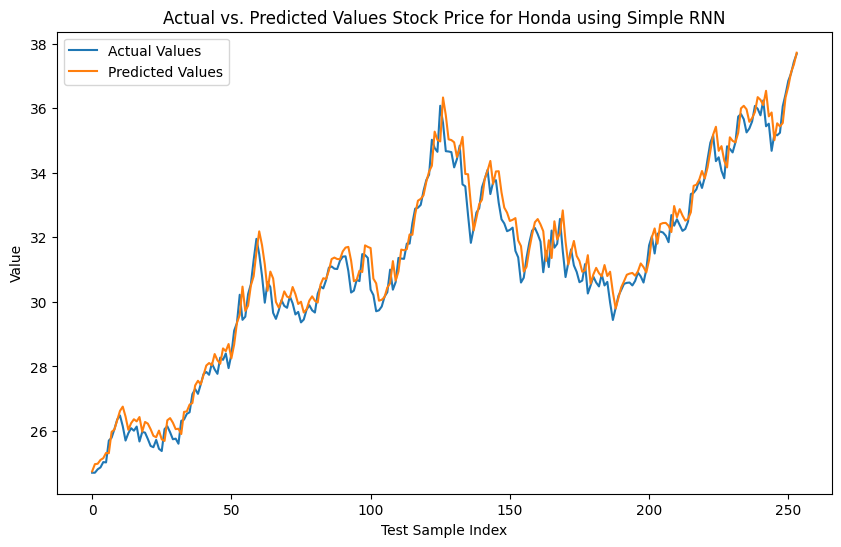

In [89]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Actual vs. Predicted Values Stock Price for Honda using Simple RNN')
plt.xlabel('Test Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [90]:
# Assuming y_test are your true values and test_predictions are the predictions from your model
mape = (mean_absolute_percentage_error(y_test, test_predictions) * 100)
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mse)  # Calculating RMSE
r2 = r2_score(y_test, test_predictions)  # Calculating R-squared score

print("Metrics used to evaluate Simple-RNN")

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R² score: {r2:.4f}")

Metrics used to evaluate Simple-RNN
MAE: 0.3816
MSE: 0.2476
RMSE: 0.4976
MAPE: 1.2325
R² score: 0.9722
